In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from pandas_datareader import data as pdr
from datetime import datetime

In [2]:
start = datetime(2016, 1, 1)
# 트럼프 당선일 : 2016/11/8, 바이든 당선일 : 2020/11/3
end = datetime(2021, 12, 31)

In [ ]:
df1 = yf.download('^GSPC', start, end)
df2 = yf.download('SPLG', start, end)

df = pd.DataFrame({'S&P500' : df1['Close'], 'SPLG' : df2['Close']})

df.bfill()
df.ffill()

## 1. 2016/01/01 ~ 2016/11/08(트럼프 당선일) ~ 2020/11/03(바이든 당선일) ~ 2021/12/31 S&P500 지수 및 SPLG 주가 그래프 변화양상 확인

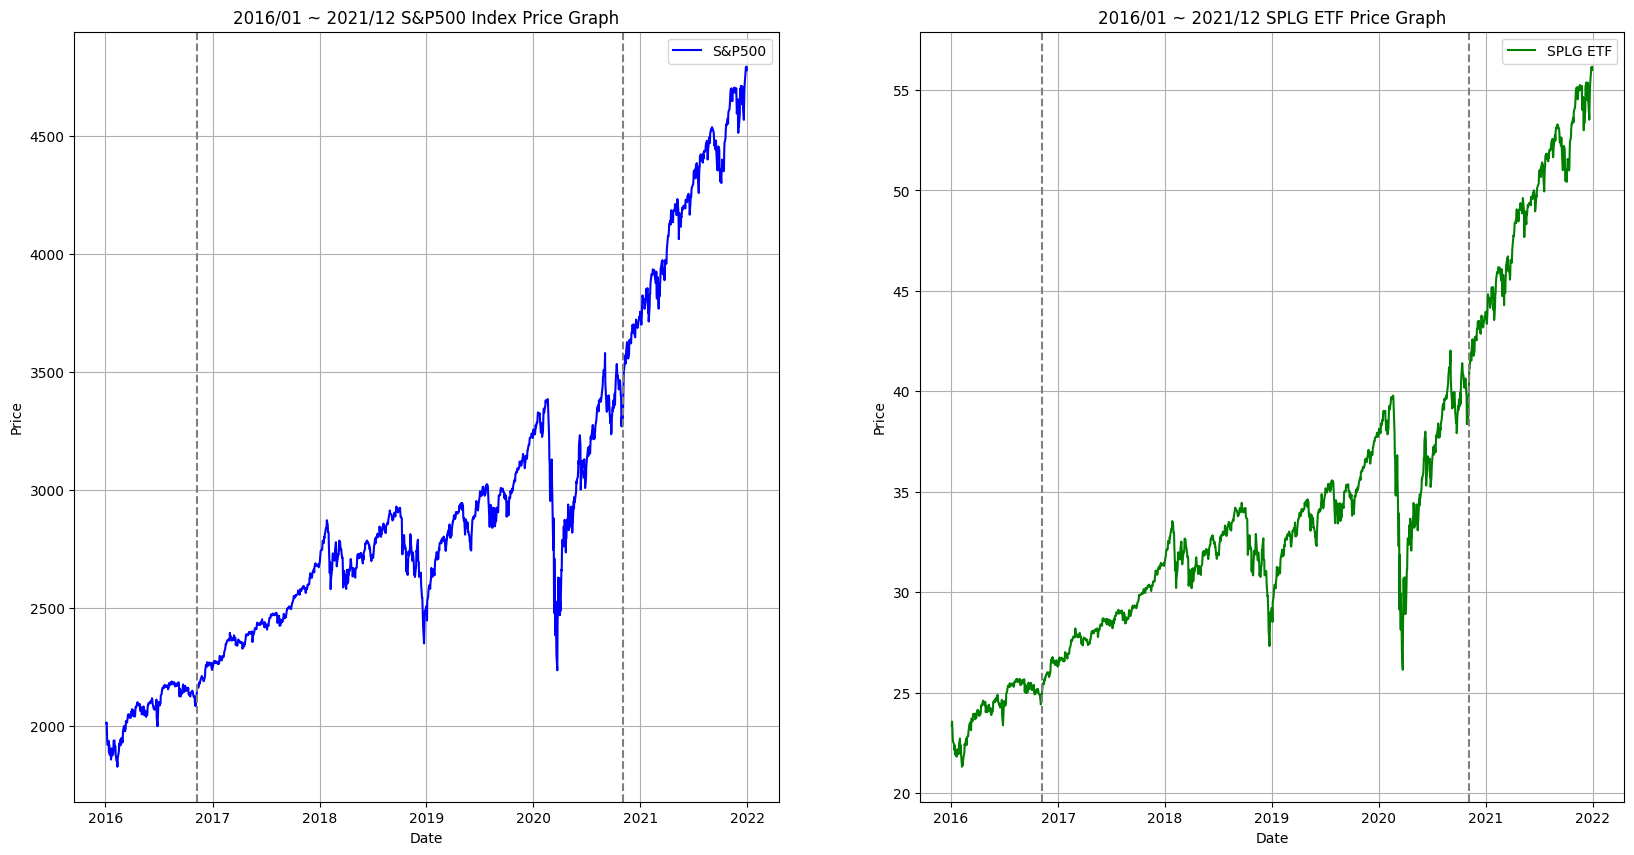

In [4]:
plt.figure(figsize = (20, 10))

plt.subplot(1, 2, 1)
plt.plot(df.index, df['S&P500'], color = 'blue', label = 'S&P500')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.axvline(x = datetime(2016, 11, 8), color = 'gray', linestyle = '--')
plt.axvline(x = datetime(2020, 11, 3), color = 'gray', linestyle = '--')
plt.title('2016/01 ~ 2021/12 S&P500 Index Price Graph')

plt.subplot(1, 2, 2)
plt.plot(df.index, df['SPLG'], color = 'green', label = 'SPLG ETF')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.axvline(x = datetime(2016, 11, 8), color = 'gray', linestyle = '--')
plt.axvline(x = datetime(2020, 11, 3), color = 'gray', linestyle = '--')
plt.title('2016/01 ~ 2021/12 SPLG ETF Price Graph')

plt.show()

### SPLG는 S&P500을 추종하므로, 연간수익률은 상동. 따라서 그래프 개형 동일

---
---
---

## 2. 트럼프 당선일 하루 전 ~ 1년 후 / 바이든 당선일 하루 전 ~ 1년 후 SPLG에 일정 금액 투자 시 수익률 및 원금대비 수익금 계산

### 트럼프 당선일 : 2016/11/8, 바이든 당선일 : 2020/11/3

- 초기투자금 100만 원, 매달 10만 원씩 투자를 가정함.
- 매매수수료를 0.25%로 가정함.
- 배당소득세 15.4%를 반영함.
- 환율정보 reference : https://spot.wooribank.com/pot/Dream?withyou=FXXRT0016

In [5]:
# - - - 초기 세팅 - - -
매매수수료 = 0.0025 # (0.25%)
배당소득세 = 0.154 # (2천만 원 미만 : 15.4% 세율 적용)

# 트럼프 당선 시
초기투자금1 = 1000000 / 1160 # 2016년 11월 평균 환율
매월투자금1 = 100000 / 1140 # 2016년 11월 ~ 2017년 11월 평균 환율

# 바이든 당선 시
초기투자금2 = 1000000 / 1115 # 2020년 11월 평균 환율
매월투자금2 = 100000 / 1135 # 2020년 11월 ~ 2021년 11월 평균 환율

---

### 2-1. 트럼프 당선일 하루 전에 100만 원, 월말에 10만원씩 투자 시 1년 후 투자 성과 분석

In [6]:
start = datetime(2016, 11, 7) ; end = datetime(2017, 11, 30)

df = yf.download('SPLG', start, end)
df.rename(columns = {'Adj Close' : 'SPLG 주가'}, inplace = True) # 조정종가로 판단함

# 결측치 채워넣기
df = df.bfill()
df = df.ffill()

[*********************100%%**********************]  1 of 1 completed


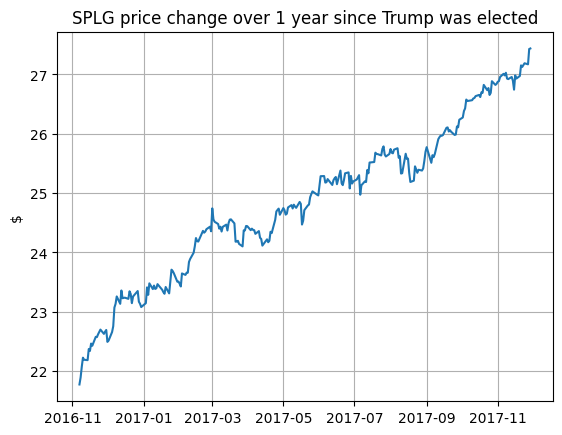

In [7]:
plt.plot(df.index, df['SPLG 주가'])
plt.ylabel('$')
plt.grid(True)
plt.title('SPLG price change over 1 year since Trump was elected')
plt.show()

In [8]:
# 배당금 구하기
ticker = yf.Ticker('SPLG')
div = ticker.dividends.tz_localize(None)

In [9]:
# 데이터프레임에 배당금 데이터를 concat
df['SPLG 배당금'] = div
df.fillna(0, inplace = True) # 배당금 지급되지 않는 날짜는 NaN으로 처리되어 있으므로 0으로 매워준다.

In [10]:
# df_m : 월말투자 고려, li_monthlast 리스트에 매월 마지막 날을 추출하기 위한 임시 데이터프레임
df_m = df

df_m['date'] = df_m.index
df_m = df_m.groupby(by = [df.index.year, df.index.month]).last() # 매월 마지막 날만 필터링

li_monthlast = df_m['date'].to_list() # 리스트화(매월 마지막 날이 저장됨)

# - - - 트럼프 당선일 하루 전날인 2016-11-07 정보 insert - - -
li_monthlast.insert(0, datetime(2016, 11, 7))

print(li_monthlast[0]) ; print(li_monthlast[-1])

2016-11-07 00:00:00
2017-11-29 00:00:00


In [ ]:
df['투자금'] = 0 # 투자금 열 추가 생성 및 초기화

for i, m in enumerate(li_monthlast):
    if i == 0: # 초기 투자
        df['투자금'].loc[m] = 초기투자금1 # 100만 원
    else:
        df['투자금'].loc[m] = 매월투자금1 # 10만 원

In [ ]:
# 열 추가 생성 및 초기화, SPLG 금액은 SPLG 총 매수금액 의미
df[['SPLG 주식수', 'SPLG 금액', '합계', '원금누계']] = 0

for m in range(len(df)):

    if m == 0: # 첫 iteration(2016/11/07, 추가한 열들 초깃값 init.)
        df['원금누계'].iloc[m] = df['투자금'].iloc[m]

        df['합계'].iloc[m] = df['투자금'].iloc[m] * (1 - 매매수수료) # 투자금 실 합계(수수료 제함)

        df['SPLG 금액'].iloc[m] = df['합계'].iloc[m]

        df['SPLG 주식수'].iloc[m] = df['SPLG 금액'].iloc[m] / df['SPLG 주가'].iloc[m]

    else:
        df['합계'].iloc[m] = df['투자금'].iloc[m] * (1 - 매매수수료) + \
                            df['SPLG 주가'].iloc[m] * df['SPLG 주식수'].iloc[m - 1] + \
                            df['SPLG 배당금'].iloc[m] * df['SPLG 주식수'].iloc[m - 1] * (1 - 배당소득세)

        if df['투자금'].iloc[m] > 0: # 매월 말일에 10만 원씩 투자하므로 주식 수의 변동을 고려한다.
            df['SPLG 금액'].iloc[m] = df['합계'].iloc[m]
            df['SPLG 주식수'].iloc[m] = df['SPLG 금액'].iloc[m] / df['SPLG 주가'].iloc[m]

        else: # 주식 수는 변함없다. 주식 수를 먼저 구하고 금액을 산정해야 함에 유의한다.
            df['SPLG 주식수'].iloc[m] = df['SPLG 주식수'].iloc[m - 1] # 전일과 동일하므로.
            df['SPLG 금액'].iloc[m] = df['SPLG 주식수'].iloc[m] * df['SPLG 주가'].iloc[m]

        df['원금누계'].iloc[m] = df['원금누계'].iloc[m - 1] + df['투자금'].iloc[m]

In [13]:
# 데이터프레임 가독성 향상을 위해 재배치 및 확인
df = df[['SPLG 주가', 'SPLG 주식수', 'SPLG 금액', 'SPLG 배당금', '투자금', '합계', '원금누계']]

In [ ]:
# 누적수익률 확인을 위해 주가백분율 및 전략백분율 산출
df['주가백분율'] = df['SPLG 주가'] / df['SPLG 주가'].iloc[0] # iloc[0]은 2016년 11월 7일(트럼프 당선일 하루 전 초기투자일)
df['전략백분율'] = df['합계'] / df['원금누계']

df.dropna(inplace = True)

print(df)

In [15]:
# 수익률 구하기, 엑셀 파일화
SPLG수익률 = df['SPLG 주가'].iloc[-1] / df['SPLG 주가'].iloc[0] - 1

총투자금 = df['투자금'].sum()
전략수익률 = df['합계'].iloc[-1] / 총투자금 - 1

print(f"SPLG ETF 수익률 : {round(SPLG수익률, 2)}")
print(f"전략 수익률 : {round(전략수익률, 2)}, 총투자금 = $ {총투자금}, 순수익 = $ {df['합계'].iloc[-1] - 총투자금}")
df.to_excel(f'트럼프 당선 후 1년 월말투자 백테스트결과(수익률 {round(전략수익률, 2) * 100}%).xlsx')

SPLG ETF 수익률 : 0.26
전략 수익률 : 0.17, 총투자금 = $ 2002.4198427102237, 순수익 = $ 334.14368759237414


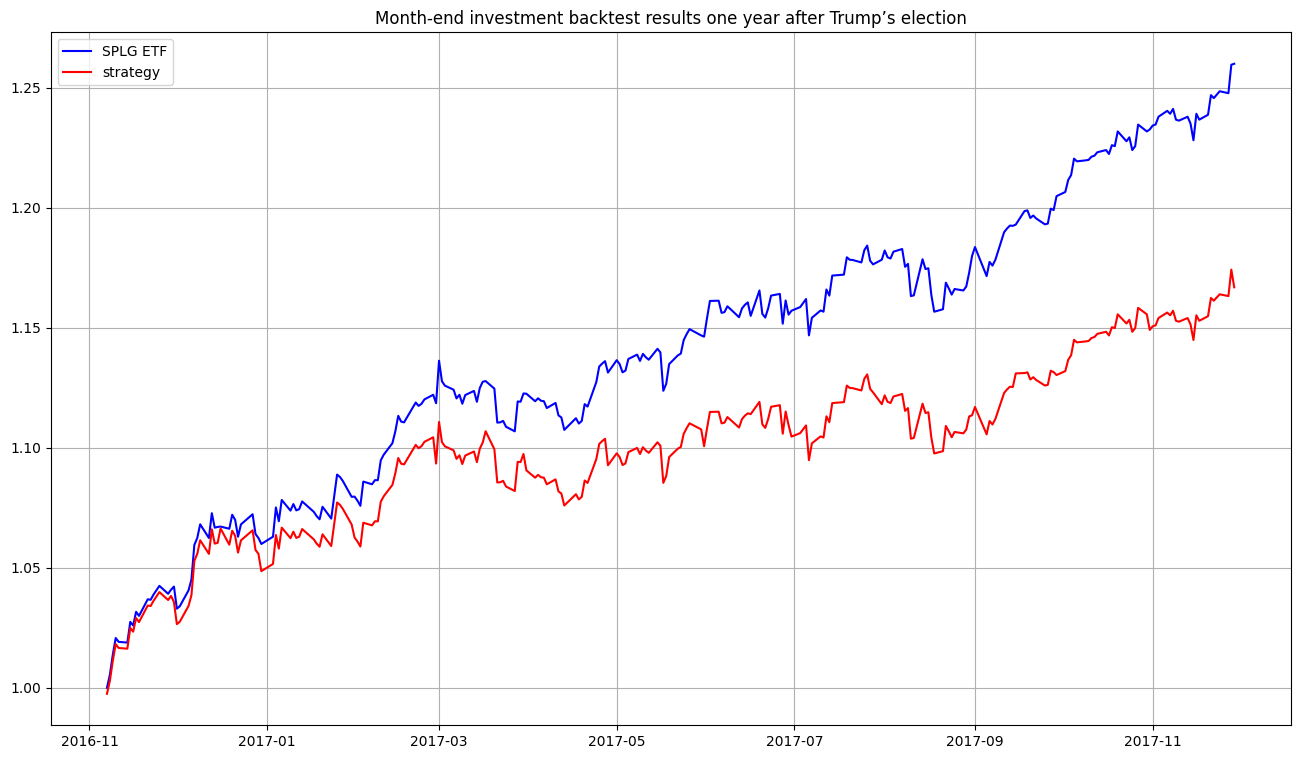

In [16]:
# 그래프로 확인
plt.figure(figsize = (16, 9))

plt.plot(df.index, df['주가백분율'], color = 'blue', label = 'SPLG ETF')
plt.plot(df.index, df['전략백분율'], color = 'red', label = 'strategy')
plt.grid(True)
plt.legend()

plt.title("Month-end investment backtest results one year after Trump’s election")

plt.show()

---

### 2-2. 바이든 당선일 하루 전에 100만 원, 월말에 10만원씩 투자 시 1년 후 투자 성과 분석

In [17]:
start = datetime(2020, 11, 2) ; end = datetime(2021, 11, 30)

df = yf.download('SPLG', start, end)
df.rename(columns = {'Adj Close' : 'SPLG 주가'}, inplace = True) # 조정종가로 판단함

# 결측치 채워넣기
df = df.bfill()
df = df.ffill()

[*********************100%%**********************]  1 of 1 completed


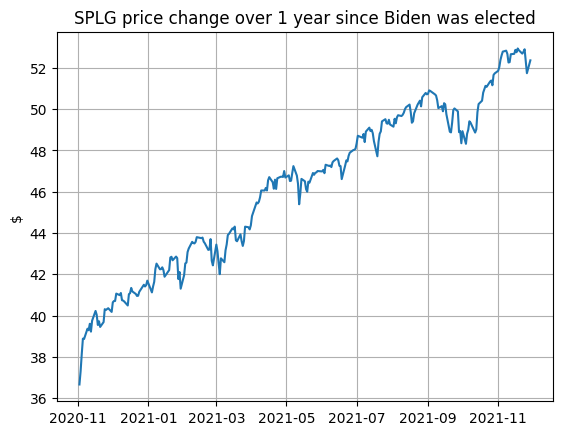

In [18]:
plt.plot(df.index, df['SPLG 주가'])
plt.ylabel('$')
plt.grid(True)
plt.title('SPLG price change over 1 year since Biden was elected')
plt.show()

In [19]:
# 배당금 구하기
ticker = yf.Ticker('SPLG')
div = ticker.dividends.tz_localize(None)

In [20]:
# 데이터프레임에 배당금 데이터를 concat
df['SPLG 배당금'] = div
df.fillna(0, inplace = True) # 배당금 지급되지 않는 날짜는 NaN으로 처리되어 있으므로 0으로 매워준다.

In [21]:
# df_m : 월말투자 고려, li_monthlast 리스트에 매월 마지막 날을 추출하기 위한 임시 데이터프레임
df_m = df

df_m['date'] = df_m.index
df_m = df_m.groupby(by = [df.index.year, df.index.month]).last() # 매월 마지막 날만 필터링

li_monthlast = df_m['date'].to_list() # 리스트화(매월 마지막 날이 저장됨)

# - - - 바이든 당선일 하루 전날인 2020-11-02 정보 insert - - -
li_monthlast.insert(0, datetime(2020, 11, 2))

print(li_monthlast[0]) ; print(li_monthlast[-1])

2020-11-02 00:00:00
2021-11-29 00:00:00


In [ ]:
df['투자금'] = 0

for i, m in enumerate(li_monthlast):
    if i == 0: # 초기 투자
        df['투자금'].loc[m] = 초기투자금2 # 100만 원
    else:
        df['투자금'].loc[m] = 매월투자금2 # 10만 원

In [ ]:
# 열 추가 생성 및 초기화, SPLG 금액은 SPLG 총 매수금액 의미
df[['SPLG 주식수', 'SPLG 금액', '합계', '원금누계']] = 0

for m in range(len(df)):

    if m == 0: # 첫 iteration(2020/11/02, 추가한 열들 초깃값 init.)
        df['원금누계'].iloc[m] = df['투자금'].iloc[m]

        df['합계'].iloc[m] = df['투자금'].iloc[m] * (1 - 매매수수료) # 투자금 실 합계(수수료 제함)

        df['SPLG 금액'].iloc[m] = df['합계'].iloc[m]

        df['SPLG 주식수'].iloc[m] = df['SPLG 금액'].iloc[m] / df['SPLG 주가'].iloc[m]

    else:
        df['합계'].iloc[m] = df['투자금'].iloc[m] * (1 - 매매수수료) + \
                            df['SPLG 주가'].iloc[m] * df['SPLG 주식수'].iloc[m - 1] + \
                            df['SPLG 배당금'].iloc[m] * df['SPLG 주식수'].iloc[m - 1] * (1 - 배당소득세)

        if df['투자금'].iloc[m] > 0: # 매월 말일에 10만 원씩 투자하므로 주식 수의 변동을 고려한다.
            df['SPLG 금액'].iloc[m] = df['합계'].iloc[m]
            df['SPLG 주식수'].iloc[m] = df['SPLG 금액'].iloc[m] / df['SPLG 주가'].iloc[m]

        else: # 주식 수는 변함없다. 주식 수를 먼저 구하고 금액을 산정해야 함에 유의한다.
            df['SPLG 주식수'].iloc[m] = df['SPLG 주식수'].iloc[m - 1] # 전일과 동일하므로.
            df['SPLG 금액'].iloc[m] = df['SPLG 주식수'].iloc[m] * df['SPLG 주가'].iloc[m]

        df['원금누계'].iloc[m] = df['원금누계'].iloc[m - 1] + df['투자금'].iloc[m]

In [24]:
# 데이터프레임 가독성 향상을 위해 재배치 및 확인
df = df[['SPLG 주가', 'SPLG 주식수', 'SPLG 금액', 'SPLG 배당금', '투자금', '합계', '원금누계']]

In [ ]:
# 누적수익률 확인을 위해 주가백분율 및 전략백분율 산출
df['주가백분율'] = df['SPLG 주가'] / df['SPLG 주가'].iloc[0] # iloc[0]은 2020년 11월 2일(바이든 당선일 하루 전 초기투자일)
df['전략백분율'] = df['합계'] / df['원금누계']

df.dropna(inplace = True)

In [26]:
# 수익률 구하기, 엑셀 파일화
SPLG수익률 = df['SPLG 주가'].iloc[-1] / df['SPLG 주가'].iloc[0] - 1

총투자금 = df['투자금'].sum()
전략수익률 = df['합계'].iloc[-1] / 총투자금 - 1

print(f"SPLG ETF 수익률 : {round(SPLG수익률, 2)}")
print(f"전략 수익률 : {round(전략수익률, 2)}, 총투자금 = $ {총투자금}, 순수익 = $ {df['합계'].iloc[-1] - 총투자금}")
df.to_excel(f'바이든 당선 후 1년 월말투자 백테스트결과(수익률 {round(전략수익률, 2) * 100}%).xlsx')

SPLG ETF 수익률 : 0.43
전략 수익률 : 0.26, 총투자금 = $ 2042.2354358862922, 순수익 = $ 532.1860575205446


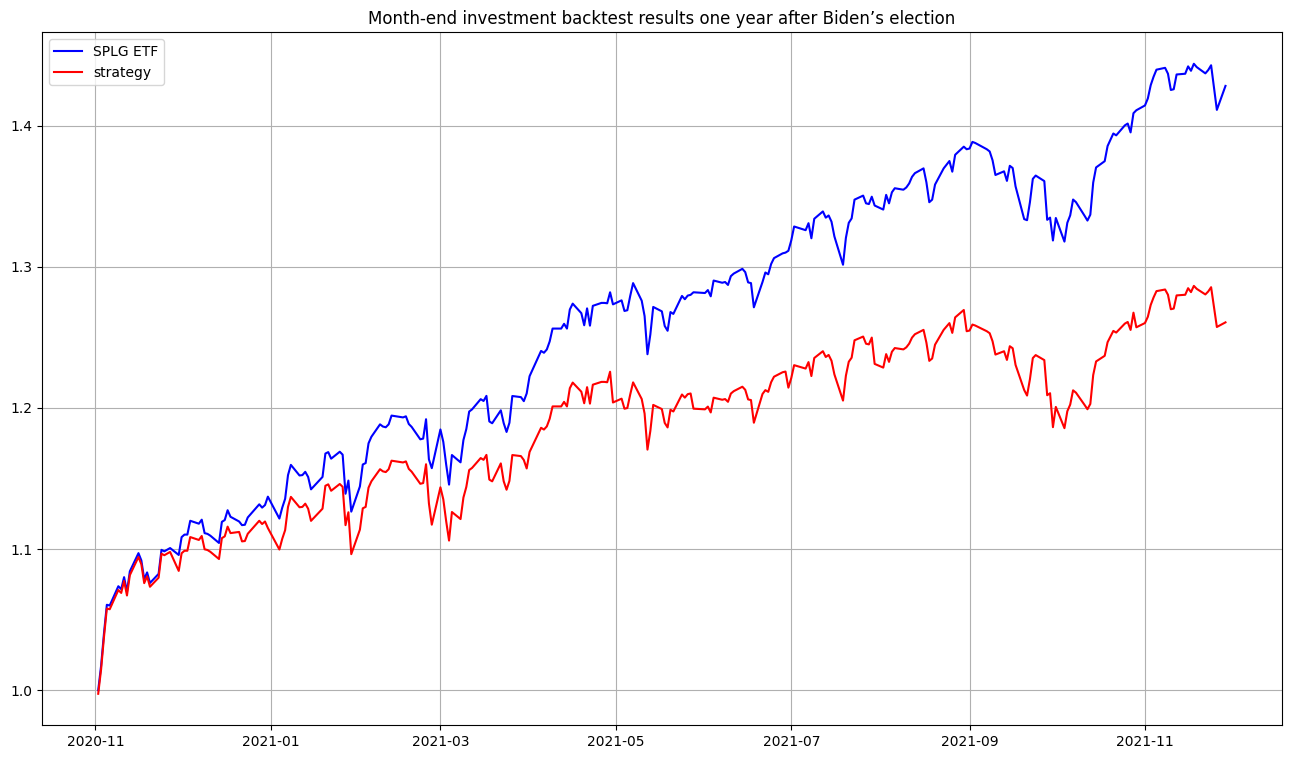

In [29]:
# 그래프로 확인
plt.figure(figsize = (16, 9))

plt.plot(df.index, df['주가백분율'], color = 'blue', label = 'SPLG ETF')
plt.plot(df.index, df['전략백분율'], color = 'red', label = 'strategy')
plt.grid(True)
plt.legend()

plt.title("Month-end investment backtest results one year after Biden’s election")

plt.show()